In [1]:
!pip install segmentation_models_pytorch -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.4 MB/s eta 0:00:00


In [2]:
import os
from tqdm.notebook import tqdm
import gc
from torch.nn import Parameter
import torch.nn.functional as F
import torch.nn as nn
import math
import timm
import pandas as pl
import torch
import numpy as np
from torch.amp import GradScaler
import cv2
import random
from tqdm.notebook import tqdm
from torch.autograd import Variable
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import segmentation_models_pytorch as smp
import torchvision.transforms as T
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import albumentations as album

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(228)

In [4]:
train_msk = np.load('/kaggle/input/ioai-2025-preparation-class-lesson-8-homework/msk_array.npy')
train_images = sorted(os.listdir('/kaggle/input/ioai-2025-preparation-class-lesson-8-homework/data/train'))
test_images = sorted(os.listdir('/kaggle/input/ioai-2025-preparation-class-lesson-8-homework/data/test'))
test_msk = np.zeros((len(test_images), train_msk.shape[1], train_msk.shape[2]))

train_images = [f'/kaggle/input/ioai-2025-preparation-class-lesson-8-homework/data/train/{path}' for path in train_images]
test_images = [f'/kaggle/input/ioai-2025-preparation-class-lesson-8-homework/data/test/{path}' for path in test_images]
len(train_images)

545

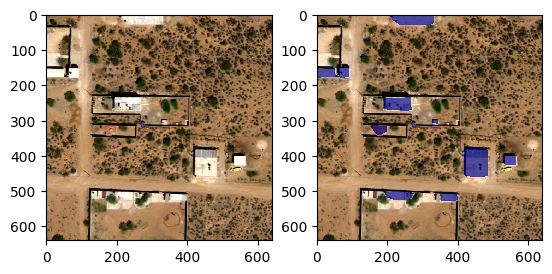

In [5]:
im = Image.open(train_images[15])
mask = ndimage.shift(train_msk[15], (-25,-26))
masked = np.ma.masked_where(mask == 0, mask)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
plt.show()

In [6]:
def get_train_transforms():
    train_transform = [    
        # album.RandomCrop(height=640, width=640, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.2,
        )
    ]
    return album.Compose(train_transform)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_image, msks, transforms, mode='train'):

        self.path_image = path_image
        self.msks = msks
        # Resize input image
        self.image_size = 512
        self.mode = mode
        self.transforms = transforms

    def resize(self, img):
        return  cv2.resize(
            img, (self.image_size, self.image_size))

    def __len__(self):
        return len(self.path_image)

    def __getitem__(self, i):

        img = cv2.imread(self.path_image[i])
        msk = self.msks[i]
        
        msk = ndimage.shift(msk, (-25,-25))
        
        msk = msk[:, :, None]

        # msk = self.resize(msk)
        # img = self.resize(img)

        # aug = album.PadIfNeeded(min_height=512, min_width=512, p=1)

        # augmented = aug(image=img, mask=msk)
        
        # img = augmented['image']
        # msk = augmented['mask']

        if self.mode == 'train':
            transformed = self.transforms(image=img, mask=msk)
            img = transformed['image']
            msk = transformed['mask']


        # img = (img / 255.) - 0.5
        
        norm = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ]
        )
        img = norm(img)

        # img = img.permute((2,0,1))
        # print(img.shape)
        # img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)

        return img, msk

In [7]:
# ds = Dataset(train_images[:-70], train_msk[:-70],get_train_transforms(),'train')

In [8]:
# img, msk = ds[0]

In [9]:
# !pip install timm -q
# import timm
# timm.list_models()

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # ENCODER = 'resnet50'
        # ENCODER_WEIGHTS = 'imagenet'
        # CLASSES = [1]
        # ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
        
        # # create segmentation model with pretrained encoder
        # self.unet = smp.Unet(
        #     encoder_name=ENCODER, 
        #     encoder_weights=ENCODER_WEIGHTS, 
        #     classes=len(CLASSES), 
        #     activation=ACTIVATION,
        # )
        # print(self.unet)
        # print(torch.load(pretrained_path))
        # self.unet = (torch.load(pretrained_path, map_location='cpu'))

        self.unet = smp.UnetPlusPlus(
            'tu-tf_efficientnetv2_b3',
             encoder_weights='imagenet',
             classes=1,
             decoder_channels=[512, 256, 128, 64, 32],
        )
        
    def forward(self, x):
        y = self.unet(x)
        return y

In [11]:
import torch
import numpy as np

def dice_coeff(pred, target, eps=1e-6):
    """
    Compute the Dice coefficient (intersection over union) for binary segmentation.
    
    Args:
        pred (Tensor): The predicted mask (after sigmoid activation).
        target (Tensor): The ground truth mask.
        eps (float): Small value to avoid division by zero.
    
    Returns:
        float: The Dice coefficient.
    """
    # Ensure predictions and targets are binary
    pred = (pred > 0.5).float()  # Binarize predictions
    target = target.float()  # Ensure target is float (it should already be binary)

    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)
    
    dice = (2. * intersection + eps) / (union + eps)
    return dice


In [12]:
gc.collect()
torch.cuda.empty_cache()

batch_size = 8
valid_batch_size = 8
epochs = 10
lr = 1e-3/2
clip_grad_norm = 15.28
DEVICE = 'cuda'
params_train = {'batch_size': batch_size, 'shuffle': True, 'drop_last': True, 'num_workers': 2}
params_val = {'batch_size': batch_size, 'shuffle': False, 'drop_last': False, 'num_workers': 2}


train_loader = torch.utils.data.DataLoader(Dataset(train_images[:-70], train_msk[:-70],get_train_transforms(),'train'), **params_train)
val_loader = torch.utils.data.DataLoader(Dataset(train_images[-70:], train_msk[-70:],get_train_transforms(),'valid'), **params_val)

model = Model().cuda()
num_train_steps = int(len(train_loader) / batch_size  * epochs)
loss_func= smp.losses.DiceLoss(mode="binary", smooth=1) #from_logits=False)
# define loss function
# loss_func = smp.utils.losses.DiceLoss()

scaler = GradScaler('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs, 1e-6)


best_model = -1
best_val_res = -1

val_outputs = -1
for epoch in range(epochs):
    model.train()
    average_loss = 0
    tk0 = tqdm(enumerate(train_loader), total = len(train_loader))
    # train_logs = train_epoch.run(train_loader)
    for batch_number,  (img, target)  in tk0:
        optimizer.zero_grad()
        img = img.to(DEVICE)
        target = target.to(DEVICE)
        # continue
        with torch.amp.autocast('cuda'):
            outputs = model(img)
            # outputs = outputs.permute((0,2,3,1))[:,:,:,0].unsqueeze(-1)
            # outputs = outputs[:,0, ...]
            # outputs = outputs.permute()
            loss = loss_func(outputs, target)
    
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
    
        average_loss += loss.cpu().detach().numpy()
        tk0.set_postfix(loss=average_loss / (batch_number + 1),lr = scheduler.get_last_lr()[0], stage="train", epoch = epoch)

    model.eval()
    val_loss = 0
    val_dice = 0  # Initialize dice coefficient accumulator
    with torch.no_grad():
        for batch_number, (img, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
            img = img.to(DEVICE)
            target = target.to(DEVICE)

            with torch.amp.autocast('cuda'):
                outputs = model(img)
                # outputs = outputs.permute((0,2,3,1))[:,:,:,0].unsqueeze(-1)
                loss = loss_func(outputs, target)
                val_outputs = outputs

            val_loss += loss.cpu().detach().numpy()
            
            # Compute Dice coefficient for the current batch
            # dice = dice_coeff(outputs, target)
            dice = 1 - loss.cpu().detach().numpy()
            val_dice += dice

    # Print validation loss and Dice score after every epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    if avg_val_dice > best_val_res:
        best_val_res = avg_val_dice
        best_model = model
    
    
    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {average_loss / len(train_loader):.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}")

model.safetensors:   0%|          | 0.00/57.9M [00:00<?, ?B/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.3681, Validation Loss: 0.2658, Validation Dice: 0.7342


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.2547, Validation Loss: 0.2260, Validation Dice: 0.7740


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.2149, Validation Loss: 0.2177, Validation Dice: 0.7823


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.1871, Validation Loss: 0.1954, Validation Dice: 0.8046


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.1806, Validation Loss: 0.1905, Validation Dice: 0.8095


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.1647, Validation Loss: 0.1933, Validation Dice: 0.8067


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.1562, Validation Loss: 0.1940, Validation Dice: 0.8060


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.1461, Validation Loss: 0.1898, Validation Dice: 0.8102


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.1460, Validation Loss: 0.1883, Validation Dice: 0.8117


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.1430, Validation Loss: 0.1898, Validation Dice: 0.8102


In [13]:
def tta(model, imgs, augs, temp):

    preds = []

    for cur_img, aug in zip(imgs, [None] + augs):
    
        with torch.amp.autocast('cuda'):
            outputs = model(cur_img)
        outputs = outputs.permute((0,2,3,1))[:,:,:,0]

        if aug is not None:
            outputs = np.stack([aug(image=temp, mask=out.cpu().numpy())['mask'] for out in outputs])
        else:
            outputs = outputs.cpu().numpy()
        
        preds.append(outputs)

    final_preds = np.stack(preds)
    final_preds = final_preds.mean(axis=0)
    return final_preds

In [14]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path_image, msks, augs):

        self.path_image = path_image
        self.msks = msks
        self.augs = augs
        self.image_size = 512
        # Resize input image
    def resize(self, img):
        return  cv2.resize(
            img, (self.image_size, self.image_size))
        
    def __len__(self):
        return len(self.path_image)

    def __getitem__(self, i):

        img = cv2.imread(self.path_image[i])
        msk = self.msks[i]

        # img = self.resize(img)

        imgs = [img]
    
        imgs = imgs + [aug(image=img)['image'] for aug in self.augs]

        final_imgs = []

        for cur_img in imgs:

            norm = T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                ]
            )
            cur_img = norm(cur_img)
            final_imgs.append(cur_img)

        # img = img.permute((2,0,1))
        # print(img.shape)
        # img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)

        return final_imgs, msk


In [15]:
test_augs = [album.HorizontalFlip(p=1), album.VerticalFlip(p=1), album.Compose([album.HorizontalFlip(p=1),album.VerticalFlip(p=1)],is_check_shapes=False)]
params_val = {'batch_size': batch_size, 'shuffle': False, 'drop_last': False, 'num_workers': 2}
test_loader = torch.utils.data.DataLoader(TestDataset(test_images, test_msk,test_augs), **params_val)

In [16]:
preds = []
imgs_list = []
target_list = []
model.eval()
average_loss = 0
with torch.no_grad():
    for batch_number,  (imgs, _)  in tqdm(enumerate(test_loader)):
        imgs = [img.to(DEVICE) for img in imgs]

        # with torch.amp.autocast('cuda'):
        #     outputs = best_model(img)
        # print(outputs.shape)
        # outputs = outputs.permute((0,2,3,1))
        # print(outputs.shape)
        # outputs = outputs.softmax(dim=-1)
        # outputs = torch.argmax(outputs,dim=-1)
        # print(outputs.shape)

        outputs = tta(best_model, imgs, test_augs,  cv2.imread(test_images[0]))

        preds += [outputs]

preds = np.concatenate(preds)[:,:,:]

0it [00:00, ?it/s]

In [17]:
preds = (preds > 0.5).astype(np.uint8)

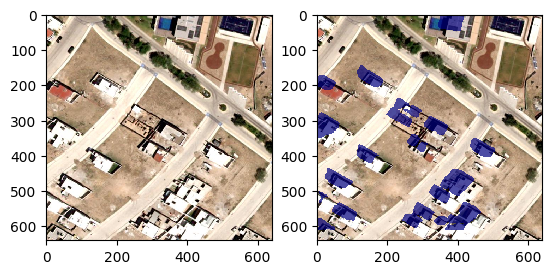

In [18]:
im = Image.open(test_images[1])
mask = ndimage.shift(preds[1], (-26,-22))
masked = np.ma.masked_where(mask == 0, mask)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
plt.show()

In [19]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

# def rle_decode(mask_rle, shape=(640, 640)):
#     '''
#     mask_rle: run-length as string formatted (start length)
#               empty predictions need to be encoded with '-'
#     shape: (height, width) of array to return 
#     Returns numpy array, 1 - mask, 0 - background
#     '''

#     img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
#     if mask_rle != '-': 
#         s = mask_rle.split()
#         starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
#         starts -= 1
#         ends = starts + lengths
#         for lo, hi in zip(starts, ends):
#             img[lo:hi] = 1
#     return img.reshape(shape, order='F')  # Needed to align to RLE direction

In [20]:
# true_list = [mask.encode(np.asfortranarray(ans))['counts'] for ans in preds]
true_list = [list_to_string(rle_encode(ans)) for ans in preds]

predict_df = pd.DataFrame()
predict_df['Id'] = [f'{x:03d}.jpg' for x in range(150)]
predict_df['Target'] = true_list
predict_df.to_csv('submission_with_tta_try.csv', index = None)